In [47]:
pip install plotly

  Using cached plotly-5.14.1-py2.py3-none-any.whl (15.3 MB)
  Using cached tenacity-8.2.2-py3-none-any.whl (24 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Iris Kmean").getOrCreate()

In [3]:
from sklearn.datasets import load_iris
import pandas as pd
df_iris = load_iris(as_frame=True)
pd_df_iris = pd.DataFrame(df_iris.data, columns = df_iris.feature_names)
pd_df_iris['target'] = pd.Series(df_iris.target)
df = spark.createDataFrame(pd_df_iris)


In [4]:
df = df.drop(df['target'])
df.show()


+-----------------+----------------+-----------------+----------------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|
+-----------------+----------------+-----------------+----------------+
|              5.1|             3.5|              1.4|             0.2|
|              4.9|             3.0|              1.4|             0.2|
|              4.7|             3.2|              1.3|             0.2|
|              4.6|             3.1|              1.5|             0.2|
|              5.0|             3.6|              1.4|             0.2|
|              5.4|             3.9|              1.7|             0.4|
|              4.6|             3.4|              1.4|             0.3|
|              5.0|             3.4|              1.5|             0.2|
|              4.4|             2.9|              1.4|             0.2|
|              4.9|             3.1|              1.5|             0.1|
|              5.4|             3.7|              1.5|          

In [5]:
from pyspark.ml.feature import VectorAssembler
X = df.columns
assembler = VectorAssembler(inputCols=X,outputCol='features')
assembled_data = assembler.transform(df)
assembled_data.select('features').show()


+-----------------+
|         features|
+-----------------+
|[5.1,3.5,1.4,0.2]|
|[4.9,3.0,1.4,0.2]|
|[4.7,3.2,1.3,0.2]|
|[4.6,3.1,1.5,0.2]|
|[5.0,3.6,1.4,0.2]|
|[5.4,3.9,1.7,0.4]|
|[4.6,3.4,1.4,0.3]|
|[5.0,3.4,1.5,0.2]|
|[4.4,2.9,1.4,0.2]|
|[4.9,3.1,1.5,0.1]|
|[5.4,3.7,1.5,0.2]|
|[4.8,3.4,1.6,0.2]|
|[4.8,3.0,1.4,0.1]|
|[4.3,3.0,1.1,0.1]|
|[5.8,4.0,1.2,0.2]|
|[5.7,4.4,1.5,0.4]|
|[5.4,3.9,1.3,0.4]|
|[5.1,3.5,1.4,0.3]|
|[5.7,3.8,1.7,0.3]|
|[5.1,3.8,1.5,0.3]|
+-----------------+
only showing top 20 rows



In [20]:
from pyspark.ml.clustering import KMeans
kmeans = KMeans(k=5, featuresCol='features')
fited = kmeans.fit(assembled_data)
transformed = fited.transform(assembled_data)

In [10]:
fited.summary.trainingCost

26.32669382578206

In [21]:
transformed.select("prediction","features").show(5)

+----------+-----------------+
|prediction|         features|
+----------+-----------------+
|         0|[5.1,3.5,1.4,0.2]|
|         0|[4.9,3.0,1.4,0.2]|
|         0|[4.7,3.2,1.3,0.2]|
|         0|[4.6,3.1,1.5,0.2]|
|         0|[5.0,3.6,1.4,0.2]|
+----------+-----------------+
only showing top 5 rows



In [13]:
#Elbow Method
costs = []
for K in range(2,20):
    kmeans = KMeans(k=K, featuresCol='features')
    fited = kmeans.fit(assembled_data)
    transformed = fited.transform(assembled_data)
    costs.append(fited.summary.trainingCost)

Exception ignored in: <function JavaWrapper.__del__ at 0x7f1993d78a60>
Traceback (most recent call last):
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 53, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'KMeans' object has no attribute '_java_obj'


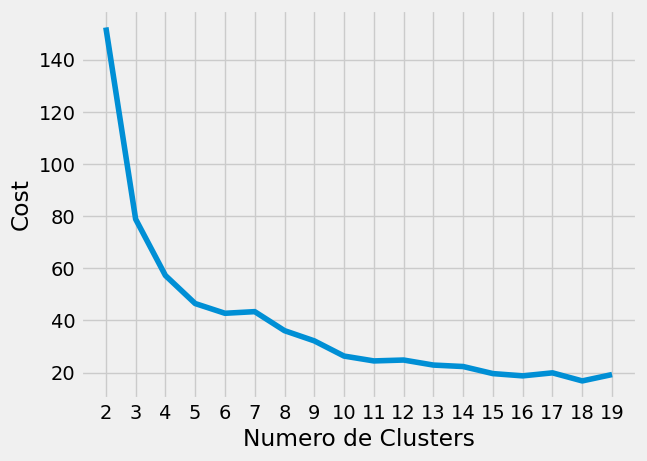

In [15]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.plot(range(2,20),costs)
plt.xticks(range(2,20))
plt.xlabel('Numero de Clusters')
plt.ylabel('Cost')
plt.show()

In [16]:
pip install kneed

Note: you may need to restart the kernel to use updated packages.


In [19]:
from kneed import KneeLocator
knee = KneeLocator(range(2,20), costs, curve='convex', direction='decreasing')
knee.elbow

5

In [22]:
#Silhouette Method
from pyspark.ml.evaluation import ClusteringEvaluator
evaluator = ClusteringEvaluator(featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')


In [23]:
silhouette_scores = []
for K in range(2,20):
    kmeans = KMeans(k=K, featuresCol='features')
    fited = kmeans.fit(assembled_data)
    transformed = fited.transform(assembled_data)
    evaluation_score = evaluator.evaluate(transformed)
    silhouette_scores.append(evaluation_score)

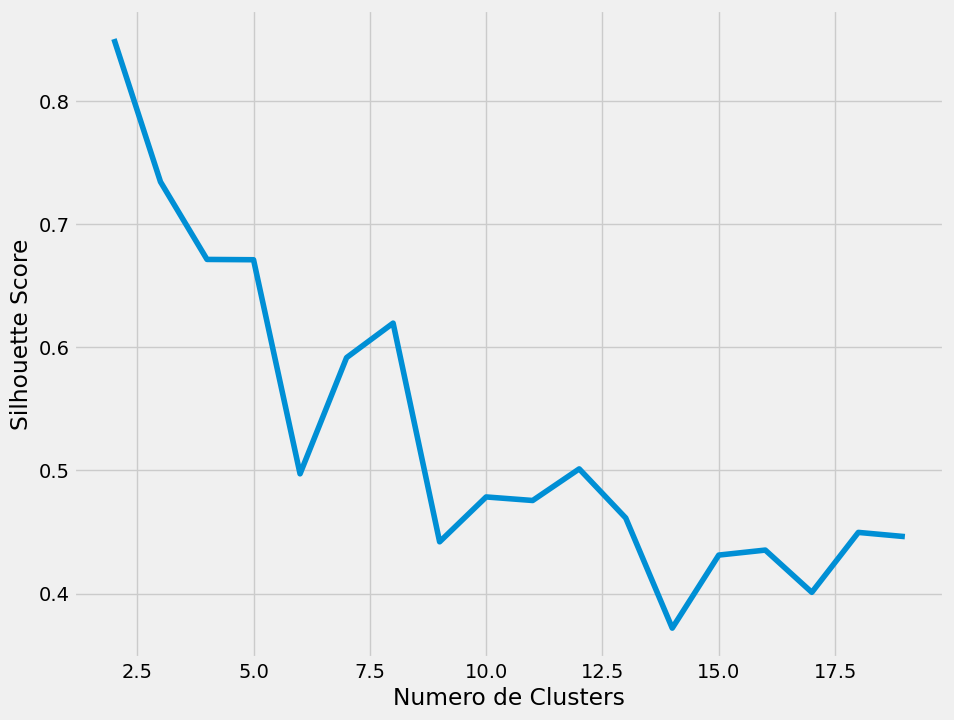

In [25]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(range(2,20),silhouette_scores)
ax.set_xlabel('Numero de Clusters')
ax.set_ylabel('Silhouette Score')
fig.show()

In [26]:
from pyspark.ml.clustering import KMeans
kmeans_3 = KMeans(k=3, featuresCol='features')
fited_3 = kmeans_3.fit(assembled_data)
transformed_3 = fited_3.transform(assembled_data)

In [27]:
from pyspark.ml.clustering import KMeans
kmeans_5 = KMeans(k=5, featuresCol='features')
fited_5 = kmeans_5.fit(assembled_data)
transformed_5 = fited_5.transform(assembled_data)

In [34]:
from  pyspark.ml.feature import PCA 
pca_3 = PCA(k=2,inputCol='features', outputCol='features_pca')
pca_model_3 = pca_3.fit(transformed_3)
pca_transformed_3 = pca_model_3.transform(transformed_3)


In [40]:
from  pyspark.ml.feature import PCA 
pca_5 = PCA(k=2,inputCol='features', outputCol='features_pca')
pca_model_5 = pca_5.fit(transformed_5)
pca_transformed_5 = pca_model_5.transform(transformed_5)


In [41]:
pca_transformed_5.select('features_pca','features','prediction').show(truncate=False)

+----------------------------------------+-----------------+----------+
|features_pca                            |features         |prediction|
+----------------------------------------+-----------------+----------+
|[-2.818239506639469,-5.646349823412796] |[5.1,3.5,1.4,0.2]|0         |
|[-2.78822344531468,-5.149951351762914]  |[4.9,3.0,1.4,0.2]|0         |
|[-2.6133745635497094,-5.182003150742136]|[4.7,3.2,1.3,0.2]|0         |
|[-2.757022276967596,-5.008653597575779] |[4.6,3.1,1.5,0.2]|0         |
|[-2.7736485960544757,-5.653707089762614]|[5.0,3.6,1.4,0.2]|0         |
|[-3.2215054997645134,-6.06828302589061] |[5.4,3.9,1.7,0.4]|0         |
|[-2.681827381868397,-5.237491192299125] |[4.6,3.4,1.4,0.3]|0         |
|[-2.876220159462373,-5.490337536526023] |[5.0,3.4,1.5,0.2]|0         |
|[-2.615982400828453,-4.74864082264099]  |[4.4,2.9,1.4,0.2]|0         |
|[-2.829609334788052,-5.2131783309535775]|[4.9,3.1,1.5,0.1]|0         |
|[-2.99541804195715,-5.972021475476269]  |[5.4,3.7,1.5,0.2]|0   

In [42]:
pca_transformed_3.select('features_pca','features','prediction').show(truncate=False)

+-----------------------------------------+-----------------+----------+
|features_pca                             |features         |prediction|
+-----------------------------------------+-----------------+----------+
|[-2.818239506639469,-5.646349823412795]  |[5.1,3.5,1.4,0.2]|0         |
|[-2.78822344531468,-5.149951351762914]   |[4.9,3.0,1.4,0.2]|0         |
|[-2.6133745635497094,-5.182003150742137] |[4.7,3.2,1.3,0.2]|0         |
|[-2.757022276967596,-5.008653597575777]  |[4.6,3.1,1.5,0.2]|0         |
|[-2.7736485960544757,-5.653707089762613] |[5.0,3.6,1.4,0.2]|0         |
|[-3.2215054997645134,-6.068283025890609] |[5.4,3.9,1.7,0.4]|0         |
|[-2.6818273818683966,-5.2374911922991245]|[4.6,3.4,1.4,0.3]|0         |
|[-2.876220159462373,-5.490337536526023]  |[5.0,3.4,1.5,0.2]|0         |
|[-2.615982400828453,-4.74864082264099]   |[4.4,2.9,1.4,0.2]|0         |
|[-2.829609334788052,-5.2131783309535775] |[4.9,3.1,1.5,0.1]|0         |
|[-2.9954180419571497,-5.972021475476267] |[5.4,3.7

In [44]:
from pyspark.ml.functions import vector_to_array
pca_features_xy_3 = pca_transformed_3.withColumn('x',vector_to_array('features_pca')[0])\
                    .withColumn('y',vector_to_array('features_pca')[1])
pca_features_xy_3.select(['x','y', 'prediction']).show()

+-------------------+-------------------+----------+
|                  x|                  y|prediction|
+-------------------+-------------------+----------+
| -2.818239506639469| -5.646349823412795|         0|
|  -2.78822344531468| -5.149951351762914|         0|
|-2.6133745635497094| -5.182003150742137|         0|
| -2.757022276967596| -5.008653597575777|         0|
|-2.7736485960544757| -5.653707089762613|         0|
|-3.2215054997645134| -6.068283025890609|         0|
|-2.6818273818683966|-5.2374911922991245|         0|
| -2.876220159462373| -5.490337536526023|         0|
| -2.615982400828453|  -4.74864082264099|         0|
| -2.829609334788052|-5.2131783309535775|         0|
|-2.9954180419571497| -5.972021475476267|         0|
|-2.8896099017002825| -5.341682515989069|         0|
|-2.7162558664209877| -5.091840576625975|         0|
|-2.2785613887433533| -4.815557989821311|         0|
| -2.857614742666976| -6.505717213265269|         0|
| -3.116326099077873| -6.665014907228346|     

In [45]:
pca_features_xy_5 = pca_transformed_5.withColumn('x',vector_to_array('features_pca')[0])\
                    .withColumn('y',vector_to_array('features_pca')[1])
pca_features_xy_5.select(['x','y', 'prediction']).show()

+-------------------+-------------------+----------+
|                  x|                  y|prediction|
+-------------------+-------------------+----------+
| -2.818239506639469| -5.646349823412796|         0|
|  -2.78822344531468| -5.149951351762914|         0|
|-2.6133745635497094| -5.182003150742136|         0|
| -2.757022276967596| -5.008653597575779|         0|
|-2.7736485960544757| -5.653707089762614|         0|
|-3.2215054997645134|  -6.06828302589061|         0|
| -2.681827381868397| -5.237491192299125|         0|
| -2.876220159462373| -5.490337536526023|         0|
| -2.615982400828453|  -4.74864082264099|         0|
| -2.829609334788052|-5.2131783309535775|         0|
|  -2.99541804195715| -5.972021475476269|         0|
| -2.889609901700283|  -5.34168251598907|         0|
|-2.7162558664209877| -5.091840576625977|         0|
|-2.2785613887433533| -4.815557989821313|         0|
| -2.857614742666976|  -6.50571721326527|         0|
| -3.116326099077873| -6.665014907228347|     

In [52]:
import plotly.io as pio
import plotly.express as px
fig = px.scatter(pca_features_xy_3.toPandas(),x='x',y='y',color='prediction')
fig.show()
pio.renderers.default = 'iframe'


In [53]:
fig = px.scatter(pca_features_xy_5.toPandas(),x='x',y='y',color='prediction')
fig.show()
pio.renderers.default = 'iframe'
